### Imports

In [5]:
# Standard imports
import collections
from dataclasses import dataclass
import gdown
import os
import numpy as np
import math
import torch
from torch import Tensor
import torch.nn as nn
from tqdm.auto import tqdm
from typing import List, Literal, Sequence, Tuple, Union

# Imports for diffusion policy
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler

# Imports for the Push-T environment
import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
import jupyviz as jviz

# always call this first
from streaming_flow_policy.all import set_random_seed
set_random_seed(0)

### Environments


In [3]:
from typing import List, Dict, Optional
import numpy as np
import gym
from gym.spaces import Box
from robomimic.envs.env_robosuite import EnvRobosuite

class RobomimicLowdimWrapper(gym.Env):
    def __init__(self, 
        env: EnvRobosuite,
        obs_keys: List[str]=[
            'object', 
            'robot0_eef_pos', 
            'robot0_eef_quat', 
            'robot0_gripper_qpos'],
        init_state: Optional[np.ndarray]=None,
        render_hw=(256,256),
        render_camera_name='agentview'
        ):

        self.env = env
        self.obs_keys = obs_keys
        self.init_state = init_state
        self.render_hw = render_hw
        self.render_camera_name = render_camera_name
        self.seed_state_map = dict()
        self._seed = None
        
        # setup spaces
        low = np.full(env.action_dimension, fill_value=-1)
        high = np.full(env.action_dimension, fill_value=1)
        self.action_space = Box(
            low=low,
            high=high,
            shape=low.shape,
            dtype=low.dtype
        )
        obs_example = self.get_observation()
        low = np.full_like(obs_example, fill_value=-1)
        high = np.full_like(obs_example, fill_value=1)
        self.observation_space = Box(
            low=low,
            high=high,
            shape=low.shape,
            dtype=low.dtype
        )

    def get_observation(self):
        raw_obs = self.env.get_observation()
        obs = np.concatenate([
            raw_obs[key] for key in self.obs_keys
        ], axis=0)
        return obs

    def seed(self, seed=None):
        np.random.seed(seed=seed)
        self._seed = seed
    
    def reset(self):
        if self.init_state is not None:
            # always reset to the same state
            # to be compatible with gym
            self.env.reset_to({'states': self.init_state})
        elif self._seed is not None:
            # reset to a specific seed
            seed = self._seed
            if seed in self.seed_state_map:
                # env.reset is expensive, use cache
                self.env.reset_to({'states': self.seed_state_map[seed]})
            else:
                # robosuite's initializes all use numpy global random state
                np.random.seed(seed=seed)
                self.env.reset()
                state = self.env.get_state()['states']
                self.seed_state_map[seed] = state
            self._seed = None
        else:
            # random reset
            self.env.reset()

        # return obs
        obs = self.get_observation()
        return obs
    
    def step(self, action):
        raw_obs, reward, done, info = self.env.step(action)
        obs = np.concatenate([
            raw_obs[key] for key in self.obs_keys
        ], axis=0)
        return obs, reward, done, info
    
    def render(self, mode='rgb_array'):
        h, w = self.render_hw
        return self.env.render(mode=mode, 
            height=h, width=w, 
            camera_name=self.render_camera_name)


def test():
    import robomimic.utils.file_utils as FileUtils
    import robomimic.utils.env_utils as EnvUtils
    from matplotlib import pyplot as plt

    dataset_path = '/home/cchi/dev/diffusion_policy/data/robomimic/datasets/square/ph/low_dim.hdf5'
    env_meta = FileUtils.get_env_metadata_from_dataset(
        dataset_path)

    env = EnvUtils.create_env_from_metadata(
        env_meta=env_meta,
        render=False, 
        render_offscreen=False,
        use_image_obs=False, 
    )
    wrapper = RobomimicLowdimWrapper(
        env=env,
        obs_keys=[
            'object', 
            'robot0_eef_pos', 
            'robot0_eef_quat', 
            'robot0_gripper_qpos'
        ]
    )

    states = list()
    for _ in range(2):
        wrapper.seed(0)
        wrapper.reset()
        states.append(wrapper.env.get_state()['states'])
    assert np.allclose(states[0], states[1])

    img = wrapper.render()
    plt.imshow(img)
    # wrapper.seed()
    # states.append(wrapper.env.get_state()['states'])

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/users/oscar/miniconda/envs/sfp/lib/python3.10/site-packages/robosuite/scripts/setup_macros.py (macros.py:55)


In [7]:
import os
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.env_utils as EnvUtils
from matplotlib import pyplot as plt

# 替换为你本地的数据集路径
dataset_path = '/home/users/oscar/miniconda/envs/sfp/lib/python3.10/site-packages/datasets/lift/ph/low_dim_v141.hdf5'

In [8]:
# 检查路径是否存在，避免后续报错
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"数据集路径不存在: {dataset_path}")

# 从数据集头部读取元数据 (Metadata)
env_meta = FileUtils.get_env_metadata_from_dataset(dataset_path=dataset_path)

# 打印看看环境的基本信息
print(f"环境名称: {env_meta['env_name']}")
print(f"环境类型: {env_meta['type']}")
print(f"环境参数: {env_meta['env_kwargs']}")

环境名称: Lift
环境类型: 1
环境参数: {'has_renderer': False, 'has_offscreen_renderer': False, 'ignore_done': True, 'use_object_obs': True, 'use_camera_obs': False, 'control_freq': 20, 'controller_configs': {'type': 'OSC_POSE', 'input_max': 1, 'input_min': -1, 'output_max': [0.05, 0.05, 0.05, 0.5, 0.5, 0.5], 'output_min': [-0.05, -0.05, -0.05, -0.5, -0.5, -0.5], 'kp': 150, 'damping': 1, 'impedance_mode': 'fixed', 'kp_limits': [0, 300], 'damping_limits': [0, 10], 'position_limits': None, 'orientation_limits': None, 'uncouple_pos_ori': True, 'control_delta': True, 'interpolation': None, 'ramp_ratio': 0.2}, 'robots': ['Panda'], 'camera_depths': False, 'camera_heights': 84, 'camera_widths': 84, 'reward_shaping': False}


In [ ]:
import robomimic.utils.obs_utils as ObsUtils

# 1. 这一步至关重要：初始化 ObsUtils
# 我们从之前读取的 env_meta 中提取观测值的定义 (specs)
# 这样 robomimic 才知道 'robot0_eef_pos' 是 low_dim 数据，而不是 rgb 图像
# ObsUtils.initialize_obs_utils_with_obs_specs(
#     obs_modality_specs={
#         "obs": env_meta["env_obs_keys"]
#     }
# )
obs_keys=[
        'object', 
        'robot0_eef_pos', 
        'robot0_eef_quat', 
        'robot0_gripper_qpos'
    ]

ObsUtils.initialize_obs_modality_mapping_from_dict(
        {'low_dim': obs_keys})

# --- 下面是你原来的代码 (现在可以正常运行了) ---

# 使用 robomimic 的工具函数创建原始环境
env = EnvUtils.create_env_from_metadata(
    env_meta=env_meta,
    render=False,
    render_offscreen=True,
    use_image_obs=False,
)

# 实例化 Wrapper
wrapper = RobomimicLowdimWrapper(
    env=env,
    obs_keys=[
        'object', 
        'robot0_eef_pos', 
        'robot0_eef_quat', 
        'robot0_gripper_qpos'
    ],
    render_hw=(256, 256),
    render_camera_name='agentview'
)

print("环境创建并封装成功！")
print(f"Action Space: {wrapper.action_space}")
print(f"Observation Space: {wrapper.observation_space}")

Created environment with name Lift
Action size is 7
环境创建并封装成功！
Action Space: Box(-1, 1, (7,), int64)
Observation Space: Box(-1.0, 1.0, (19,), float64)


1. Reset 成功 | 初始观测维度: (19,)
2. Step 成功  | Step后观测维度: (19,), Reward: 0.0


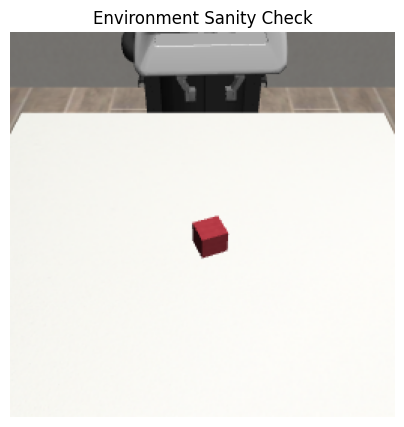

3. Render 成功 | 你应该能看到一张包含机械臂和红方块的图片。


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 测试环境重置 (Reset)
obs = wrapper.reset()
print(f"1. Reset 成功 | 初始观测维度: {obs.shape}")

# 2. 测试环境交互 (Step) - 执行一个随机动作
# 我们用全 0 动作或者随机动作测试
action = np.zeros(wrapper.action_space.shape) 
next_obs, reward, done, info = wrapper.step(action)
print(f"2. Step 成功  | Step后观测维度: {next_obs.shape}, Reward: {reward}")

# 3. 测试图像渲染 (Render) - 这是最容易报错的一步 (例如缺少 OpenGL 库)
try:
    img = wrapper.render()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title("Environment Sanity Check")
    plt.axis('off')
    plt.show()
    
    print("3. Render 成功 | 你应该能看到一张包含机械臂和红方块的图片。")
    
except Exception as e:
    print("\n[错误] 渲染失败！")
    print(f"错误信息: {e}")
    print("提示: 如果是在无头服务器(Headless Server)上，可能需要配置 EGL 或使用 xvfb-run。")

### Dataset


In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
from tqdm import tqdm

# --- 归一化工具函数 ---
# 神经网络喜欢 [-1, 1] 范围的数据，原始坐标通常不满足，所以必须归一化
def get_data_stats(data):
    data = data.reshape(-1, data.shape[-1])
    stats = {
        'min': np.min(data, axis=0),
        'max': np.max(data, axis=0)
    }
    return stats

def normalize_data(data, stats):
    # 归一化到 [0, 1]
    ndata = (data - stats['min']) / (stats['max'] - stats['min'])
    # 映射到 [-1, 1]
    ndata = ndata * 2 - 1
    return ndata

def unnormalize_data(ndata, stats):
    ndata = (ndata + 1) / 2
    data = ndata * (stats['max'] - stats['min']) + stats['min']
    return data

# --- Dataset 类定义 ---
class RobomimicDataset(Dataset):
    def __init__(self, 
                 dataset_path, 
                 obs_keys, 
                 pred_horizon, 
                 obs_horizon, 
                 action_horizon):
        
        # 参数记录
        self.pred_horizon = pred_horizon  # 预测未来多少步动作 (比如 16)
        self.obs_horizon = obs_horizon    # 使用过去多少步观测 (比如 2)
        self.action_horizon = action_horizon # 实际执行步数 (比如 8)
        self.obs_keys = obs_keys          # 需要读取哪些观测数据
        
        # 1. 读取数据到内存
        print(f"正在加载数据集: {dataset_path}")
        with h5py.File(dataset_path, 'r') as f:
            demos = f['data']
            self.all_obs = []
            self.all_actions = []
            
            # 遍历每一个演示视频 (demo_0, demo_1...)
            for key in tqdm(demos.keys(), desc="Loading"):
                demo = demos[key]
                
                # 提取并拼接 Observation (要和 Wrapper 里的顺序一致)
                # 比如: object + eef_pos + eef_quat + gripper_qpos
                obs_list = []
                for k in self.obs_keys:
                    obs_data = demo['obs'][k][:] 
                    obs_list.append(obs_data)
                obs_seq = np.concatenate(obs_list, axis=-1) # (T, 19)
                self.all_obs.append(obs_seq)
                
                # 提取 Action
                action_seq = demo['actions'][:] # (T, 7)
                self.all_actions.append(action_seq)

        # 2. 计算统计数据 (用于归一化)
        # 把所有数据拼在一起算 min 和 max
        all_obs_concat = np.concatenate(self.all_obs, axis=0)
        all_action_concat = np.concatenate(self.all_actions, axis=0)
        
        self.obs_stats = get_data_stats(all_obs_concat)
        self.action_stats = get_data_stats(all_action_concat)
        
        # 3. 预处理：归一化所有数据并建立索引
        self.normalized_obs = []
        self.normalized_actions = []
        self.indices = []
        
        for i in range(len(self.all_obs)):
            # 归一化
            n_obs = normalize_data(self.all_obs[i], self.obs_stats)
            n_action = normalize_data(self.all_actions[i], self.action_stats)
            self.normalized_obs.append(n_obs)
            self.normalized_actions.append(n_action)
            
            # 建立索引: (第几个视频, 第几帧开始)
            # 比如视频长 100帧，预测长度 16，那我们只能取到 100-16 帧
            episode_len = n_obs.shape[0]
            for start_ts in range(episode_len - self.pred_horizon):
                self.indices.append((i, start_ts))
                
        print(f"加载完成! 样本数量: {len(self.indices)}")
        print(f"Obs Stats: {self.obs_stats['min'].shape}")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        episode_idx, start_ts = self.indices[idx]
        
        n_obs = self.normalized_obs[episode_idx]
        n_action = self.normalized_actions[episode_idx]
        
        # --- 这里的逻辑是 Diffusion Policy 的核心 ---
        
        # 1. 取 Observation (过去 obs_horizon 步)
        # 为了简化，我们这里只取 [start_ts] 这一帧，并复制 obs_horizon 次
        # (标准的 Push-T 实现中，其实通常使用 start_ts : start_ts + obs_horizon)
        # 这里为了配合上面的 Wrapper，我们取 start_ts 到 start_ts + obs_horizon
        obs_seq = n_obs[start_ts : start_ts + self.obs_horizon, :]
        
        # 2. 取 Action (未来 pred_horizon 步)
        action_seq = n_action[start_ts : start_ts + self.pred_horizon, :]
        
        # 转为 PyTorch Tensor
        data = {
            'obs': torch.from_numpy(obs_seq).float(),      # shape: (obs_horizon, 19)
            'action': torch.from_numpy(action_seq).float() # shape: (pred_horizon, 7)
        }
        return data

In [16]:
# 配置参数 (这些是 Diffusion Policy 的标准参数)
pred_horizon = 16    # 预测未来 16 步
obs_horizon = 2      # 看过去 2 步
action_horizon = 8   # (这一步在 dataset 里用不到，但在推理时有用)

# 1. 实例化 Dataset
dataset = RobomimicDataset(
    dataset_path=dataset_path, # 确保这个变量是你之前定义的路径
    obs_keys=[
        'object', 
        'robot0_eef_pos', 
        'robot0_eef_quat', 
        'robot0_gripper_qpos'
    ],
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)

# 2. 实例化 DataLoader
dataloader = DataLoader(
    dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=0, # 本地调试设为 0 比较稳妥，避免多进程报错
    pin_memory=True
)

# 3. 验证一下输出形状
batch = next(iter(dataloader))
print("\n--- 数据形状检查 ---")
print(f"Obs Batch:    {batch['obs'].shape}")
print(f"Action Batch: {batch['action'].shape}")
print(f"Observation Space: {wrapper.observation_space}")

正在加载数据集: /home/users/oscar/miniconda/envs/sfp/lib/python3.10/site-packages/datasets/lift/ph/low_dim_v141.hdf5


Loading: 100%|██████████| 200/200 [00:00<00:00, 1063.21it/s]


加载完成! 样本数量: 6466
Obs Stats: (19,)

--- 数据形状检查 ---
Obs Batch:    torch.Size([64, 2, 19])
Action Batch: torch.Size([64, 16, 7])
Observation Space: Box(-1.0, 1.0, (19,), float64)


### Model

In [17]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, scale = 1):
        super().__init__()
        self.dim = dim
        self.scale = scale # added - SFP

    def forward(self, x):
        x = x * self.scale
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class ConvDownsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class ConvUpsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)

class LinearDownsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)

    def forward(self, x: Tensor):
        # Reshape input to (batch_size, -1) for fully connected layer
        batch_size, channels, seq_len = x.size()
        x = x.view(batch_size, -1)  # flatten spatial dimensions
        x = self.linear(x)
        x = x.view(batch_size, channels, seq_len)  # reshape back to original dimensions
        return x

class LinearUpsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)

    def forward(self, x: Tensor):
        # Reshape input to (batch_size, -1) for fully connected layer
        batch_size, channels, seq_len = x.size()
        x = x.view(batch_size, -1)  # flatten spatial dimensions
        x = self.linear(x)
        x = x.view(batch_size, channels, seq_len)  # reshape back to original dimensions
        return x

class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)

class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8,
                 ):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # Ensure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out

class ConditionalUnet1D (nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        updownsample_type: Literal['Conv', 'Linear'],  # added for SFP
        sin_embedding_scale,  # added for SFP
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8,
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed, scale = sin_embedding_scale), # added - SFP
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            if updownsample_type == 'Linear':  # added for SFP
                downsample_layer = LinearDownsample1d(dim_out) if not is_last else nn.Identity() #added
            elif updownsample_type == 'Conv':
                downsample_layer = ConvDownsample1d(dim_out) if not is_last else nn.Identity()
            else:
                raise ValueError(f"Unsupported updownsample_type: {updownsample_type}")
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                downsample_layer,
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            if updownsample_type == 'Linear':  # added for SFP
                upsample_layer = LinearUpsample1d(dim_in) if not is_last  else nn.Identity()
            elif updownsample_type == 'Conv':
                upsample_layer = ConvUpsample1d(dim_in) if not is_last  else nn.Identity()
            else:
                raise ValueError(f"Unsupported updownsample_type: {updownsample_type}")
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                upsample_layer,
            ]))

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("Number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: Tensor,
            timestep: Union[Tensor, float, int],
            global_cond=None,
        ) -> Tensor:
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x

### DP

In [21]:
# 基于之前的 Lift 任务设置
action_dim = 7       # 动作维度
obs_dim = 19         # 观测特征维度
obs_horizon = 2      # 观测历史长度

# 实例化模型
dp_noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim * obs_horizon,
    updownsample_type='Conv',
    sin_embedding_scale=1,
)

print("模型构建成功！")

num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
dp_noise_pred_net = dp_noise_pred_net.to(device)

Number of parameters: 6.576359e+07
模型构建成功！


In [22]:
num_epochs = 100

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema_dp = EMAModel(
    parameters=dp_noise_pred_net.parameters(),
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=dp_noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataset) * num_epochs
)

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # Note that the data is normalized in the dataset.
                # Device transfer
                nobs = nbatch['obs'].to(device)  # (B, To, O)
                naction = nbatch['action'].to(device)  # (B, Tp, A)
                B = nobs.shape[0]

                # Observation as FiLM conditioning
                obs_cond = nobs.flatten(start_dim=1)  # (B, To*O)

                # Sample noise to add to actions
                noise = torch.randn(naction.shape, device=device)  # (B, Tp, A)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,), device=device
                ).long()  # (B,)

                # Forward diffusion process: Add noise to the clean images
                # according to the noise magnitude at each diffusion iteration.
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)  # (B, Tp, A)

                # Predict the noise residual.
                noise_pred = dp_noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema_dp.step(dp_noise_pred_net.parameters())

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

# Weights of the EMA model
# is used for inference
ema_noise_pred_net_dp = dp_noise_pred_net
ema_dp.copy_to(ema_noise_pred_net_dp.parameters())

Epoch: 100%|██████████| 100/100 [10:01<00:00,  6.02s/it, loss=0.038]


In [23]:
import collections
import numpy as np
import torch
from tqdm.auto import tqdm
import imageio  # 用于保存 GIF

# 1. 准备参数和统计数据
# 确保模型处于推理模式
dp_noise_pred_net.eval()
dp_noise_pred_net.to(device)

# 从 dataset 中获取归一化统计数据
stats = {
    'obs': dataset.obs_stats,
    'action': dataset.action_stats
}

# 设置参数 (必须与训练时一致)
max_steps = 400  # 最大运行步数
obs_horizon = 2
pred_horizon = 16
action_horizon = 8
num_diffusion_iters = 100 

# 2. 重置环境
# 使用你之前定义的 wrapper
obs = wrapper.reset()

# 初始化观测队列 (用于保存过去 obs_horizon 步的观测)
# 刚开始没有历史数据，所以用第一帧重复填充
obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)

# 用于保存可视化图像和奖励
imgs = [wrapper.render()]
rewards = list()
done = False
step_idx = 0

print("开始推理 (Inference)...")

# 3. 推理循环
with tqdm(total=max_steps, desc="Eval Robomimic") as pbar:
    while not done:
        # --- A. 数据准备 ---
        # 拼接最近 obs_horizon 步的观测数据
        obs_seq = np.stack(obs_deque) # (2, 19)
        
        # 归一化
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        
        # 转 Tensor 并增加 Batch 维度
        nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)
        
        # 构造 Global Conditioning: (1, obs_horizon * 19)
        # 也就是把 (1, 2, 19) 展平成 (1, 38)
        obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)

        # --- B. 生成动作 (反向扩散) ---
        with torch.no_grad():
            # 1. 初始化纯高斯噪音
            # shape: (1, pred_horizon, action_dim) -> (1, 16, 7)
            na_traj = torch.randn(
                (1, pred_horizon, 7), 
                device=device
            )

            # 2. 设置调度器时间步
            noise_scheduler.set_timesteps(num_diffusion_iters)

            # 3. 逐步去噪
            for k in noise_scheduler.timesteps:
                # 预测噪音
                noise_pred = dp_noise_pred_net(
                    sample=na_traj,
                    timestep=k,
                    global_cond=obs_cond
                )

                # 移除噪音 (去噪一步)
                na_traj = noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=na_traj,
                ).prev_sample

        # --- C. 后处理 ---
        # 转回 CPU numpy
        na_traj = na_traj.detach().to('cpu').numpy()[0] # (16, 7)
        
        # 反归一化动作
        action_pred = unnormalize_data(na_traj, stats=stats['action'])

        # --- D. 动作切片与执行 ---
        # 这里的逻辑是：
        # 我们输入了 [t-1, t] 的观测，模型预测的是从 t-1 开始的动作序列 [t-1, t, t+1 ...]
        # 我们现在处于时间 t，所以我们要执行的是从 index 1 (即 t) 开始的动作
        start = obs_horizon - 1
        end = start + action_horizon
        
        # 取出未来 action_horizon 步的动作 (例如 8 步)
        action_chunk = action_pred[start:end, :] 
        
        # --- E. 执行动作序列 ---
        for action in action_chunk:
            # 环境交互
            obs, reward, done, info = wrapper.step(action)
            
            # 更新历史观测
            obs_deque.append(obs)
            
            # 记录数据
            rewards.append(reward)
            imgs.append(wrapper.render())
            
            # 进度更新
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            
            if step_idx >= max_steps:
                done = True
            if done:
                break

print(f"推理结束! 总得分: {max(rewards)}")

# 4. 保存结果为 GIF
save_path = "eval_robomimic.gif"
print(f"正在保存视频到: {save_path} ...")
imageio.mimsave(save_path, imgs, fps=10)
print("保存完成！请在左侧文件浏览器下载查看。")

# 在 Notebook 中直接显示（如果在本地或支持的环境）
# from IPython.display import Image
# display(Image(filename=save_path))

开始推理 (Inference)...


Eval Robomimic:   0%|          | 0/400 [00:00<?, ?it/s]

推理结束! 总得分: 1.0
正在保存视频到: eval_robomimic.gif ...
保存完成！请在左侧文件浏览器下载查看。


### SSIP